In [1]:
#ViT
import numpy as np
import pandas as pd
from memory_profiler import memory_usage

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
#from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')


#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
num_workers = 0
script = False

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


In [6]:
model = ViTBase16(n_classes=9, pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

name = 'Experiments/exp_56/model.pt'#'model.pt'#'other.pt' 
model = torch.load(name, map_location=torch.device('cpu'))

In [7]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/Jacobs_Y6/'

hdu_list = fits.open(path_cutouts + 'Cutouts/Jacobs_Y6.fits')
lenses = hdu_list[1].data.astype(np.float32)
data_pos = hdu_list[2].data
data_pos = Table(data_pos)
data_pos = data_pos.to_pandas()
#data_pos = data_pos.drop(['TILENAME', 'Candidate'], axis=1)
columns_data = data_pos.columns
hdu_list.close()
print('All sample: ', len(lenses))

data_not = pd.read_csv(path_cutouts + 'not_in_cutouts.csv')
data_not = data_not.astype({'COADD_OBJECT_ID': int})

new_data = pd.merge(data_pos, data_not, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
lenses = lenses[new_data.index]
data_pos = data_pos.iloc[new_data.index].reset_index()

dataset = ImageDataset(lenses, data_pos, np.zeros(len(new_data), dtype = np.int64), transform=transform)
print('With lensing features inside of cutout: ', len(dataset))

All sample:  496
With lensing features inside of cutout:  448


In [8]:
def search(dataset):
    prob_list = []
    search_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=num_workers, shuffle=True)
    images = len(categories)*[np.zeros((1,3,45,45))]
    all_data = len(categories)*[pd.DataFrame()]
    
    for i_batch, sample in enumerate(tqdm(search_loader)):
        #if(i_batch==5): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        
        output = model(sample_image)
    
        prob = nn.Softmax(dim=1)(output)
        prob_list.append(prob[:,0].detach().cpu().numpy()[0])
        i = prob.argmax(dim=1)
        
        new_df = pd.DataFrame(sample_data, columns=columns_data)
        new_df['Prob'] = prob[:,i].detach()
        all_data[i] = all_data[i].append(new_df, ignore_index=True)
        images[i] = np.append(images[i], np.array(sample_img), axis = 0)
    
    for i in range(len(categories)):
        images[i] = np.delete(images[i], 0, axis = 0)
    
    return(images, all_data, prob_list)
            

In [9]:
categories = ['Positives', 'Rings', 'Smooth', 'Companion', 'SDSS', 'DES_spirals', 'Crowded', 'Errors', 'Most_negatives']
images, all_data, prob_list = search(dataset)

right_data = all_data[0]
wrong_data = pd.DataFrame(columns=columns_data)

for i in range(len(all_data)):
    if(i == 0): continue
    wrong_data = wrong_data.append(all_data[i])

  0%|          | 0/448 [00:00<?, ?it/s]

In [10]:
#Default threshold of probability
print('Total: ' + str(len(lenses)))
print('Detected: {}, not detected: {} \n'.format(len(right_data), len(wrong_data)))

for i in range(len(images)):
    line = 'Labeled as {}: {}'.format(categories[i], len(images[i]))
    print(line)

    
print(' ')
ind = right_data[right_data['Prob'] > 0.75].index
print('Detected with a 0.75 threshold: '+ str(len(ind)))
ind = right_data[right_data['Prob'] > 0.8].index
print('Detected with a 0.8 threshold: '+ str(len(ind)))

Total: 448
Detected: 387, not detected: 61 

Labeled as Positives: 387
Labeled as Rings: 1
Labeled as Smooth: 7
Labeled as Companion: 11
Labeled as SDSS: 0
Labeled as DES_spirals: 0
Labeled as Crowded: 13
Labeled as Errors: 0
Labeled as Most_negatives: 29
 
Detected with a 0.75 threshold: 359
Detected with a 0.8 threshold: 353


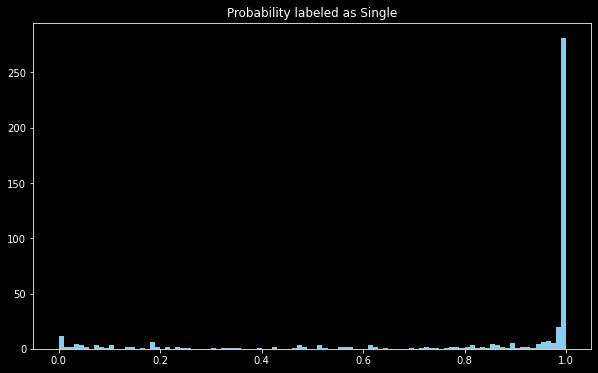

In [11]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob_list, 100, color = "skyblue")
plt.show()

In [12]:
def make_plot_all(objects, data):
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                #title = 'Mag: {:.2f}, z: {:.2f}'.format(data['MAG_APER_4_G'].values[i+j], data['DNF_ZMEAN_SOF'].values[i+j])
                title = '{:.3f}'.format(data['Prob'].values[i+j])
                print(data['COADD_OBJECT_ID'].values[i+j])
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

In [13]:
wrong_data.columns

Index(['COADD_OBJECT_ID', 'TILENAME', 'HPIX_16384', 'HPIX_4096',
       'DNF_ZMEAN_SOF', 'RA', 'DEC', 'grade', 'photoz', 'imag',
       'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z',
       'KRON_RADIUS', 'GAP_FLUX_G', 'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G',
       'SOF_BDF_FLUX_G', 'SOF_PSF_FLUX_G', 'MAG_AUTO_G', 'MAG_APER_4_G',
       'MAG_APER_8_G', 'SOF_BDF_G_1', 'SOF_BDF_G_2', 'IMAFLAGS_ISO_G',
       'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I', 'IMAFLAGS_ISO_Z', 'Candidate',
       'objectid', 'Prob'],
      dtype='object')

Not identified:
Rings
1302396180


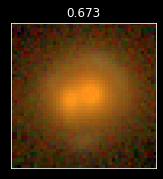

 
Smooth
924174668
1226327844
1382310111
1048865468


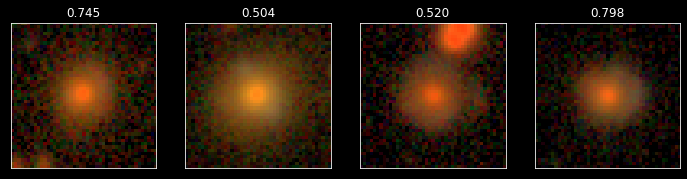

922906010
1204327104
1368303750


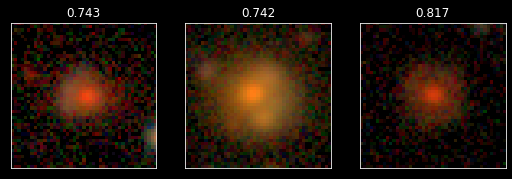

 
Companion
1324927887
1339976592
1532546424
1461036110


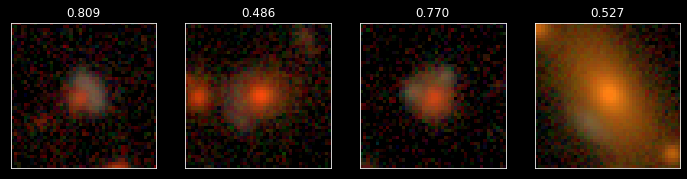

1097966135
937223786
1539517051
1558511112


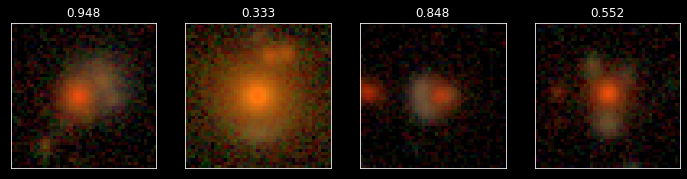

1172614654
1162461053
962781218


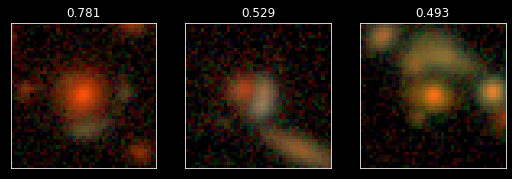

 
SDSS
 
DES_spirals
 
Crowded
1144824191
1555731785
1383664897
1022086875


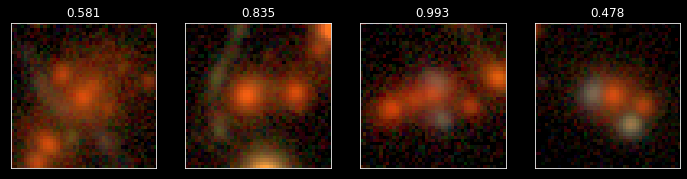

1142012795
957011358
931716591
1210817563


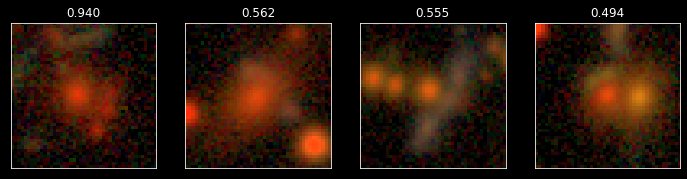

1502889148
1293358551
884307116
1371066768


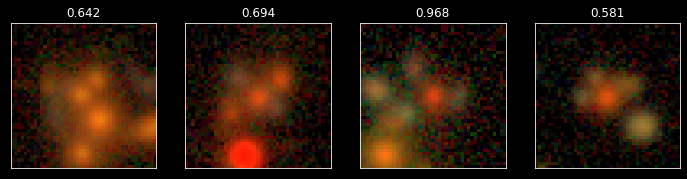

1454422743


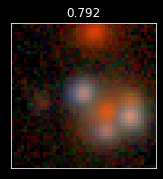

 
Errors
 
Most_negatives
1408480079
1153726289
1235910677
1011953407


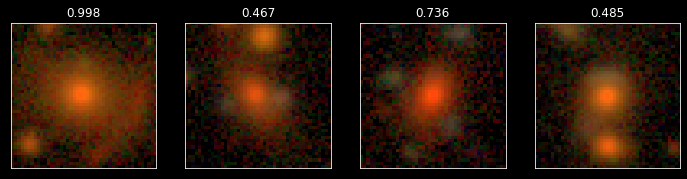

1345137000
939977129
1554912970
1394900142


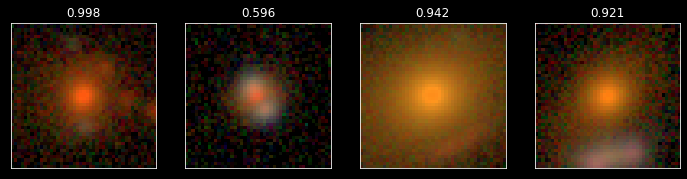

1387236198
1232668187
1333189566
992158653


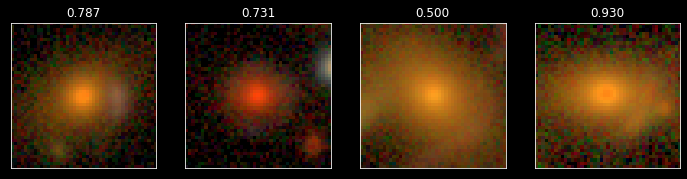

1070329410
1302104402
1530676282
1576743294


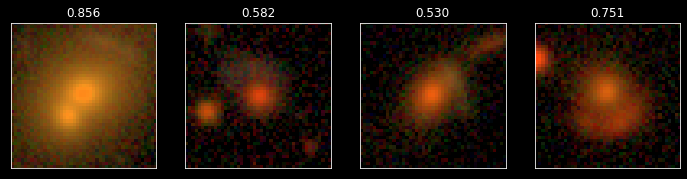

1370850549
955546194
1502820514
1279191353


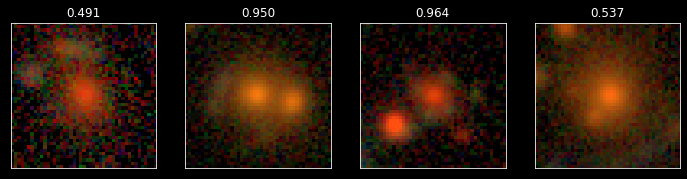

955120453
1159009987
1333534239
1317179527


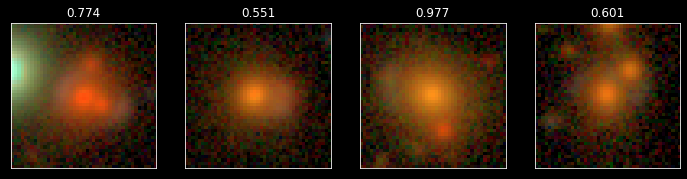

1370667532
1389753930
1356429510
1614852030


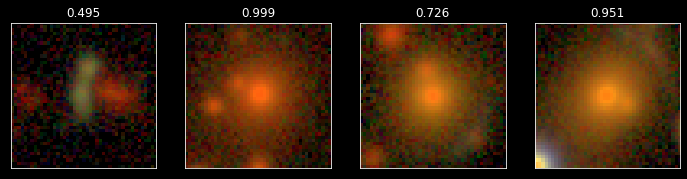

1544354650


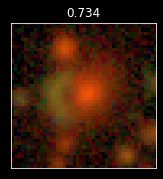

In [14]:
#Not identified
print('Not identified:')
for i in range(1, len(categories)):
    print(categories[i])
    if(len(images) == 0): 
        print(' ')
        continue
    make_plot_all(images[i], all_data[i])
    print(' ')

Identified
Positives
1569046306
1190063171
1414539080
1027961497


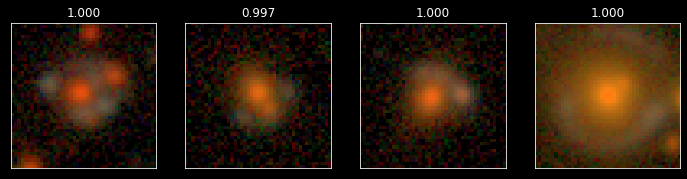

1006191814
1520310906
1287909989
1211978531


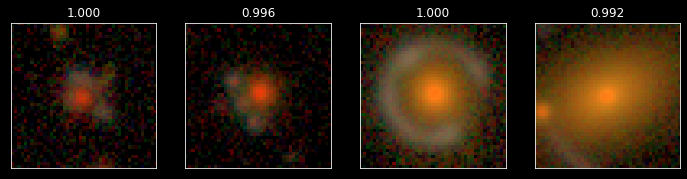

1088125980
1178407449
1148039203
1261395335


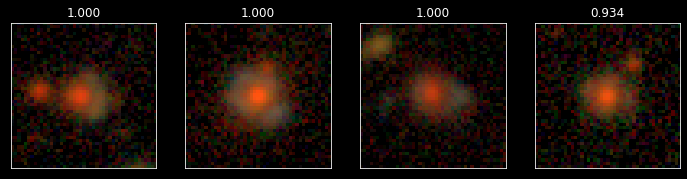

1088494058
1404582289
976812438
1453824963


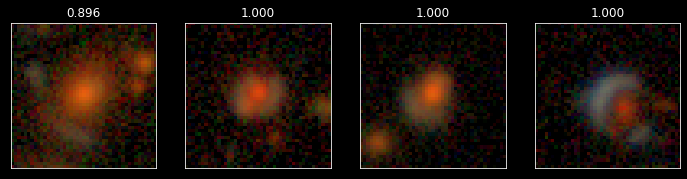

1482935849
1178164184
873987650
1323083558


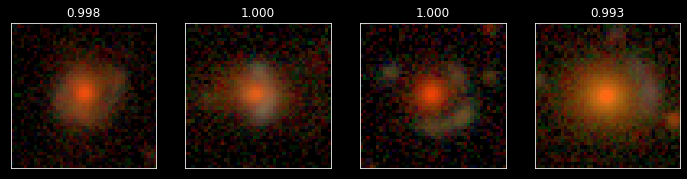

1477822151
1396857779
1164169304
1326909497


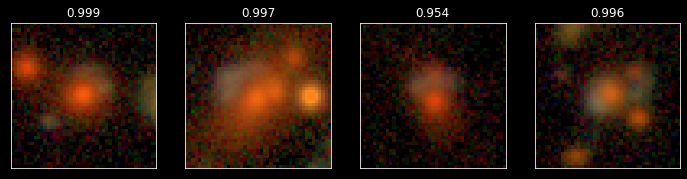

1171125930
1255097893
1162332513
1499393985


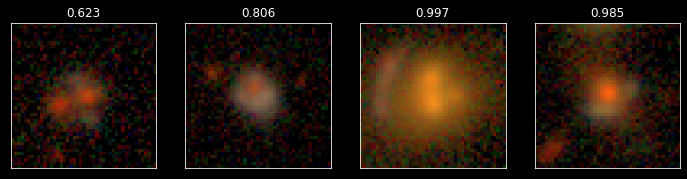

1410370257
1363860461
1189746645
1438681779


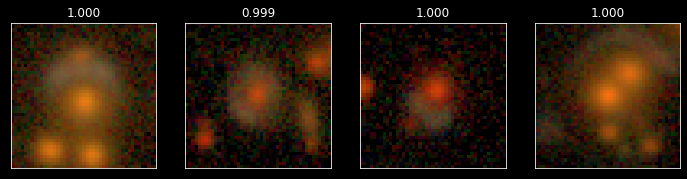

1437352224
1469887588
1386311701
1390913339


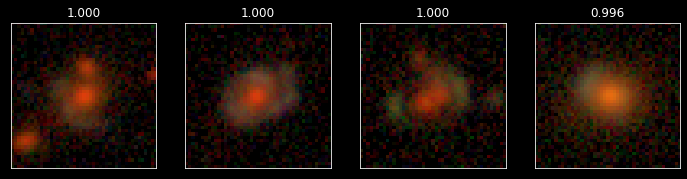

1121107640
1461199109
1337591104
920001642


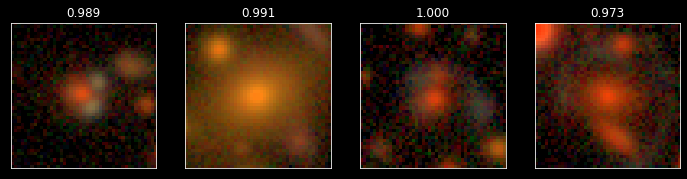

1031154124
1314224614
1277348353
1042572859


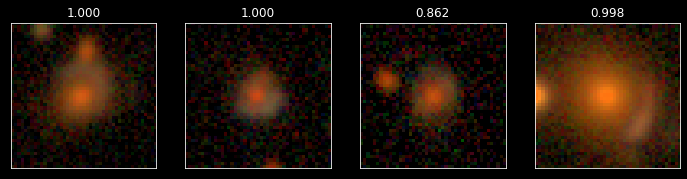

1133082429
987073198
1458095582
1360486909


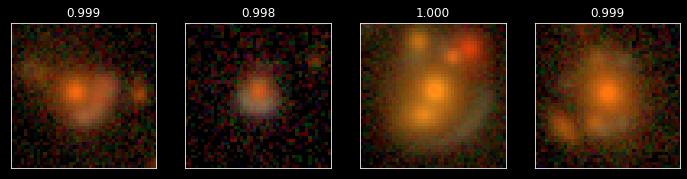

1400483784
1358779892
1104763422
1287471303


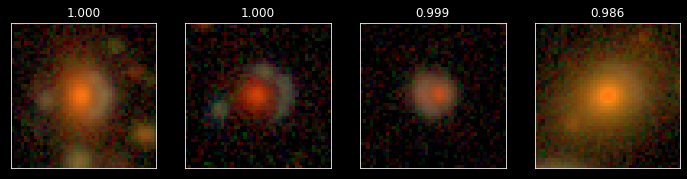

1241426939
1325130567
1535198201
1201264241


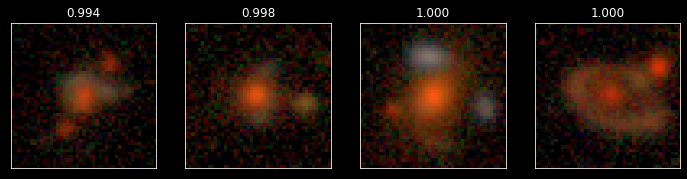

902264453
1032516085
1620013669
909363984


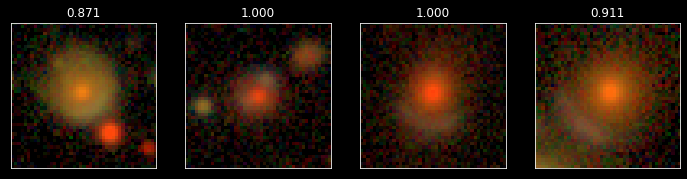

1315004041
1341869055
1535218994
1151529929


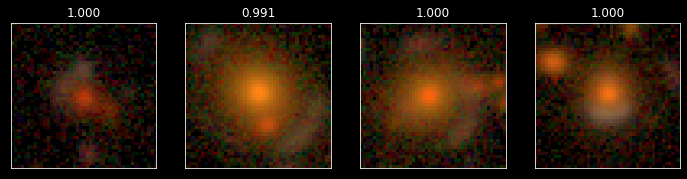

1363280855
1534084624
1229530106
1567398970


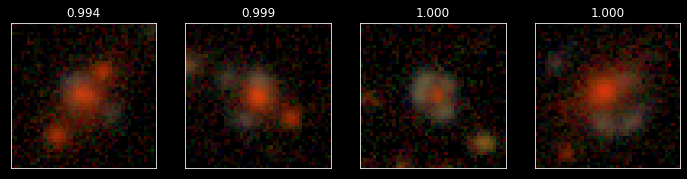

1146656000
1355312134
958711616
1431464188


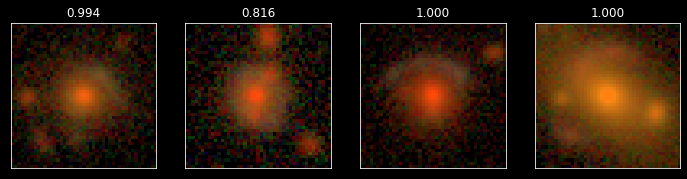

895879313
982753969
1060824131
896927669


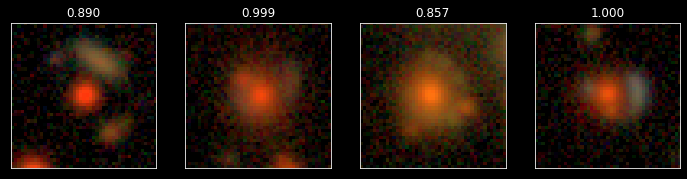

1334070236
1015716039
1015396778
1202728609


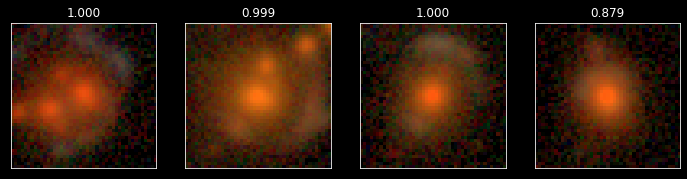

1588446577
1367145325
926358975
1218432734


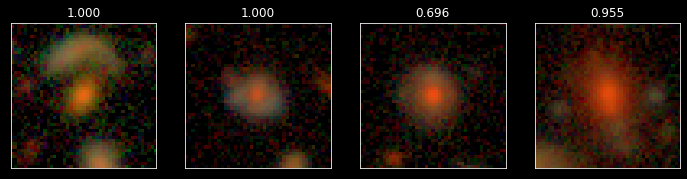

1237543091
913936319
1214520967
969674177


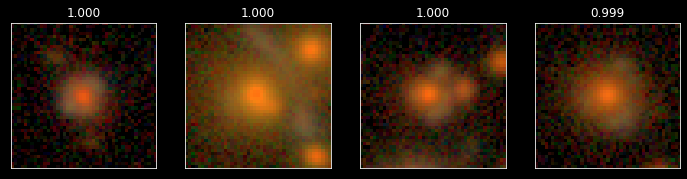

1381955752
1305035224
1055293331
1413196615


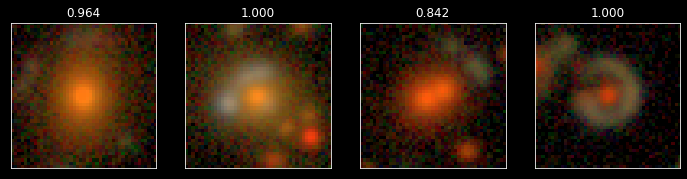

1289249195
1417265726
1253420372
1429497103


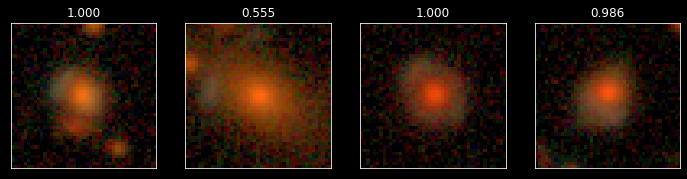

1414531628
1375955789
929174879
1318291819


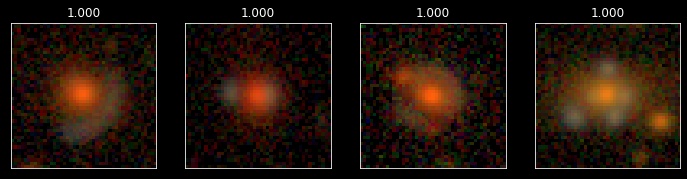

1482528707
1015482810
1337371338
1446654681


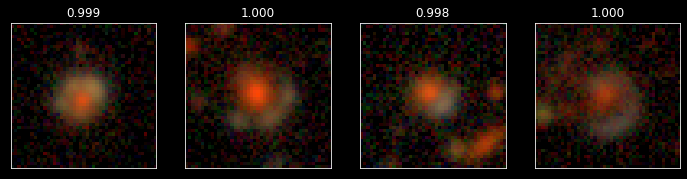

1262961390
1163516688
1302842192
1170335487


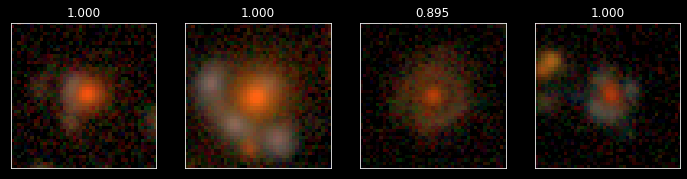

1154333895
1104760496
1491366260
1032630238


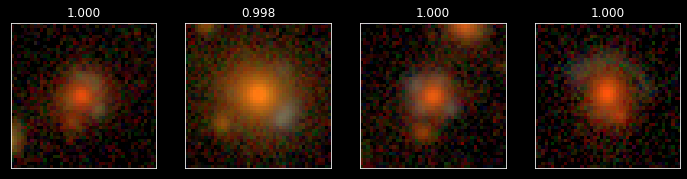

1187097045
984668871
1504184978
1301526898


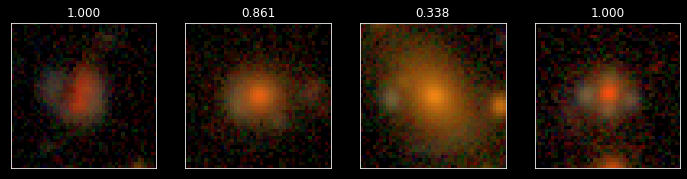

1300215437
1429276227
1403872468
1522422819


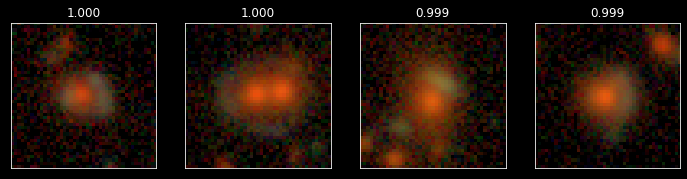

1360738327
1196984339
1153333586
1321063152


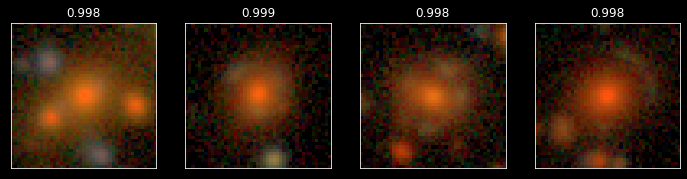

1382509325
1417914260
1122461366
1364192755


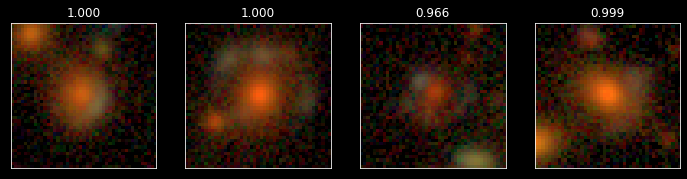

1296200194
1195735459
1254690304
1129249726


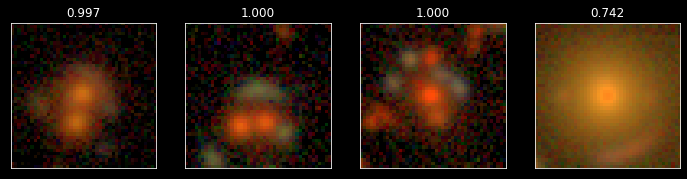

1444457615
1616630786
1522557536
1302925237


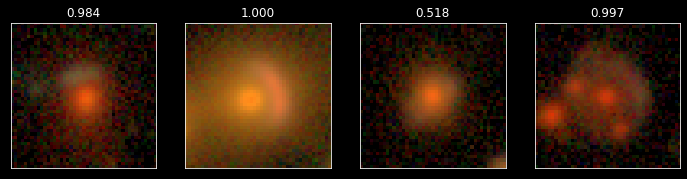

1377305692
1301081250
1051495539
1051491894


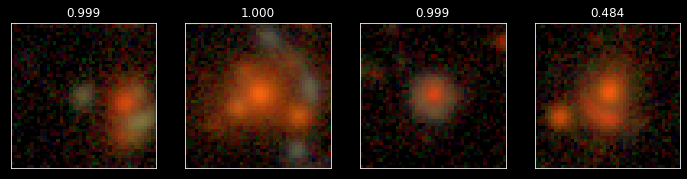

1331280148
1380201297
906297047
1237527717


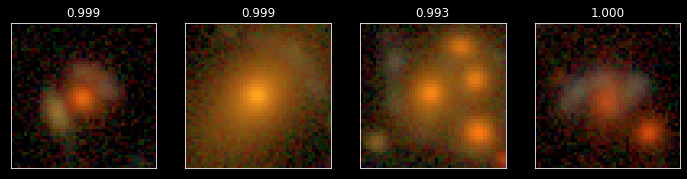

1269916975
1472301145
1293464062
1529405528


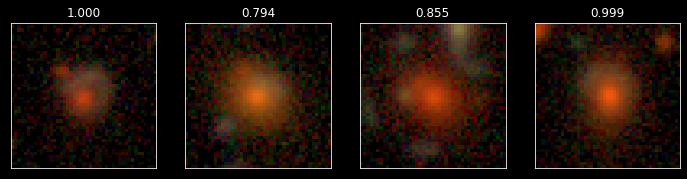

1398238029
1463283017
1526026297
1172896430


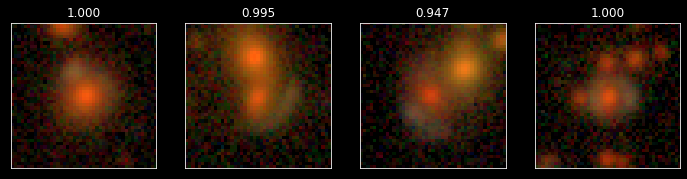

1027020579
928276016
1231169165
916084062


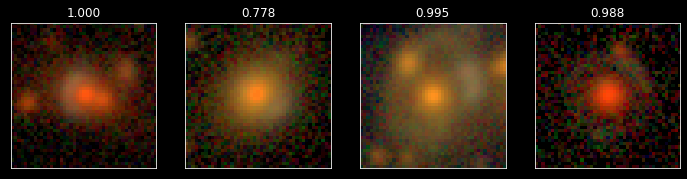

1451845442
1605209704
1452918181
1621099134


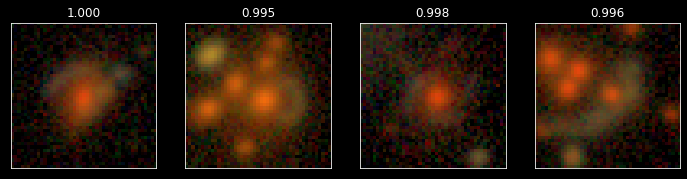

1058744217
1069698905
1370519642
1610414328


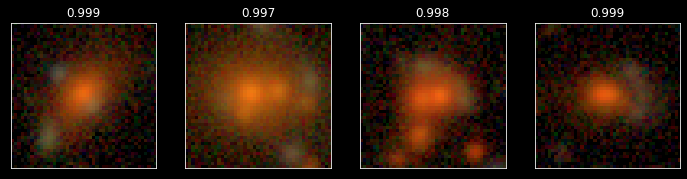

1032572319
1222328257
1471530329
1159257785


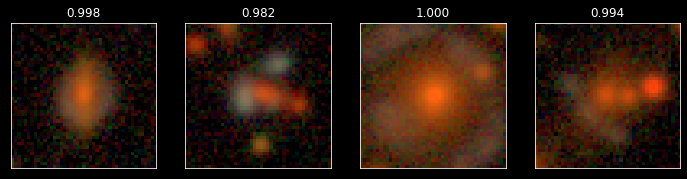

1173896612
1224505431
1209117221
1358003440


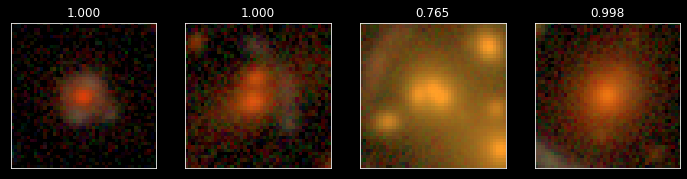

1394738694
1336392414
1449752819
1240557273


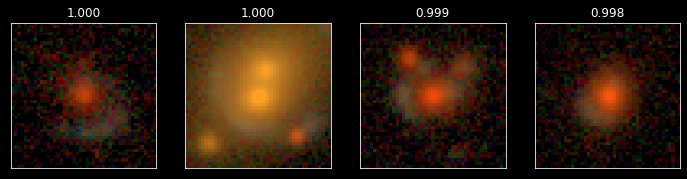

963722618
1423965682
1230981106
1521719117


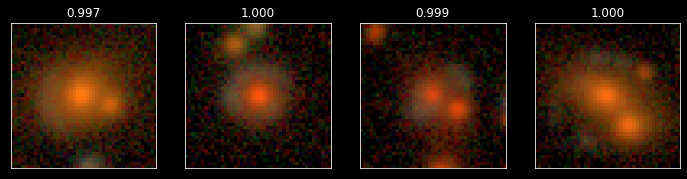

1425763095
1512709228
1366134685
981794120


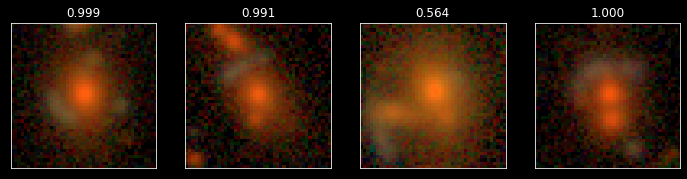

1445651907
1561967167
1406976127
906132378


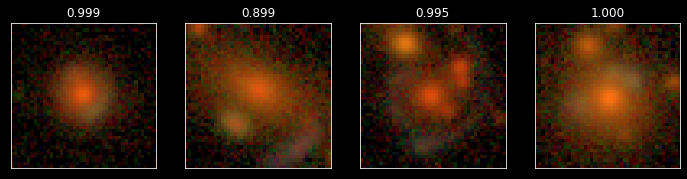

1437028794
1418184071
916018816
1243545869


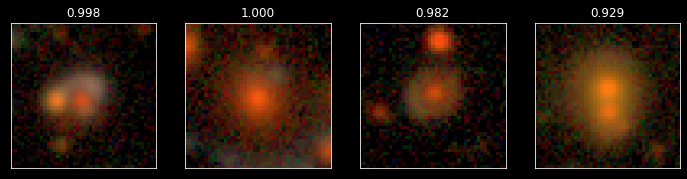

1051762909
1530473645
1483061451
1286831512


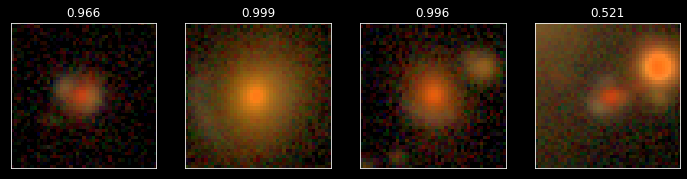

1510652342
1369699810
1042565305
1328384049


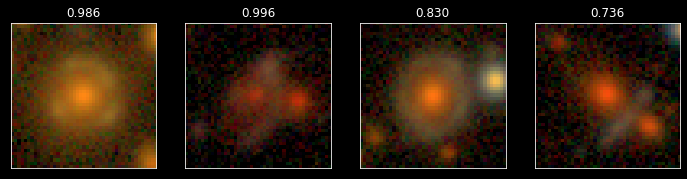

1503701111
1077357392
1056483458
1536678003


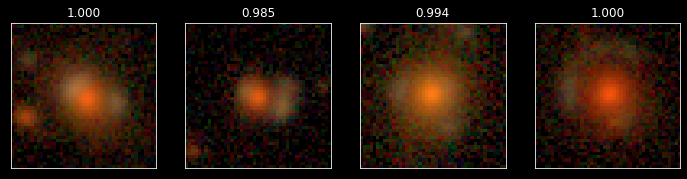

1117638986
884176328
1079352949
1186271916


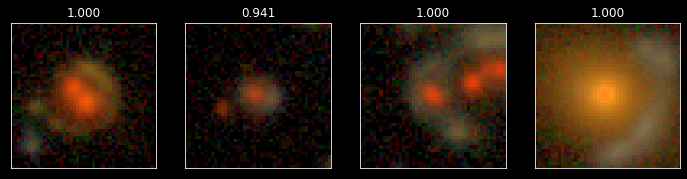

1193586965
1048920254
957012430
945275549


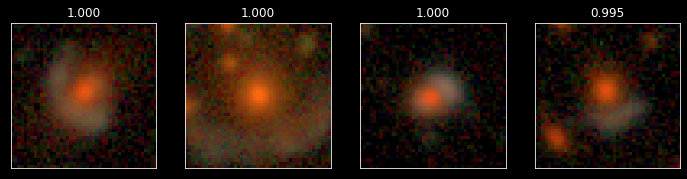

1529154996
1610019605
1208164784
1469110768


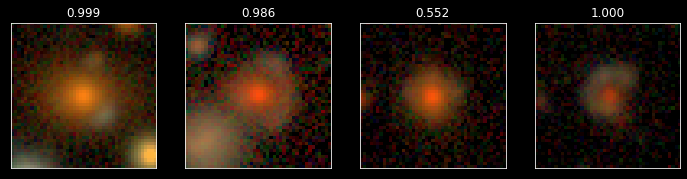

885335814
910349095
1519335321
1429256248


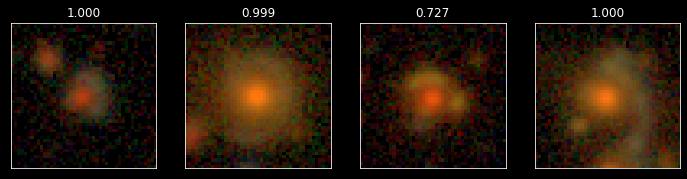

1309246601
1272147895
1577636680
1610316947


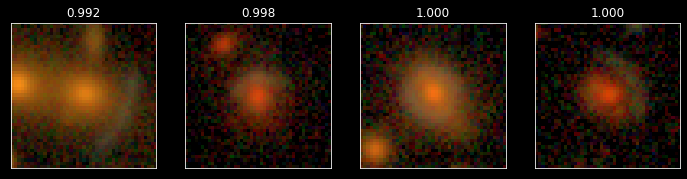

1448527037
1545295456
1360521121
1133966811


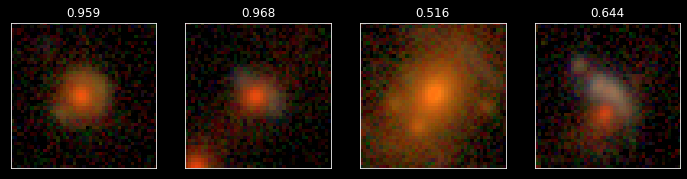

1275177571
1135365822
910130782
1463632393


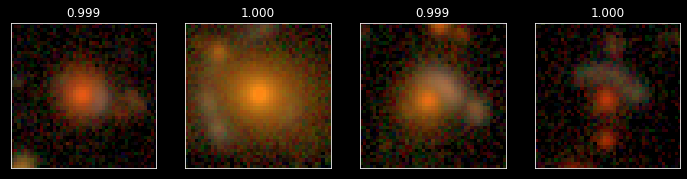

1513432178
1430614124
977402902
1005730815


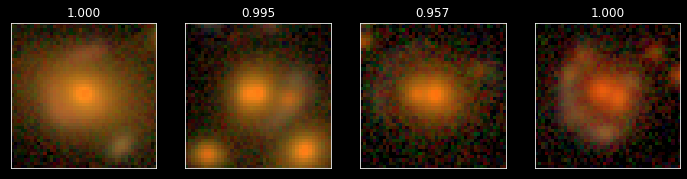

1097396471
1183753773
1235391858
995519978


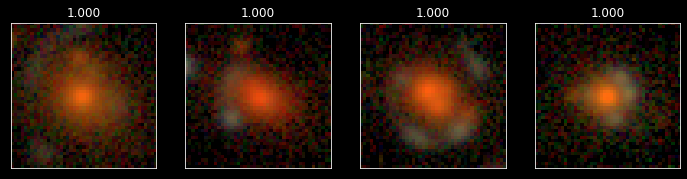

1389731679
1567663479
1419269561
1425127607


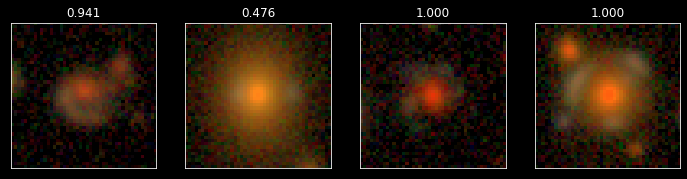

1447194025
1403871221
1568765304
1225134030


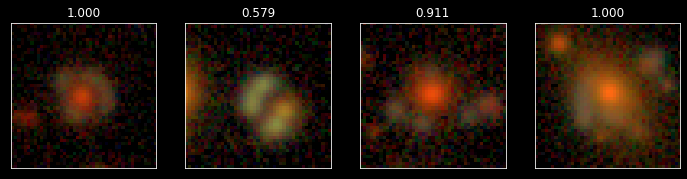

1011752156
1612075297
1088115093
1449725103


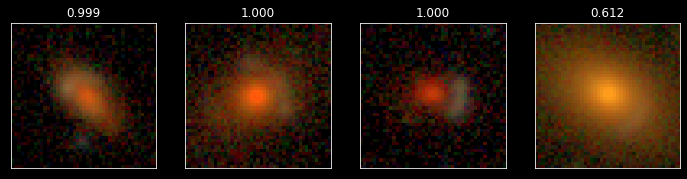

962178024
1054556683
1203869644
996246835


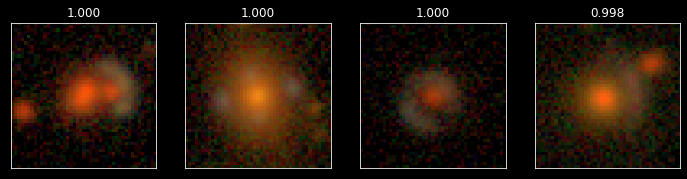

1375013657
1452635200
1418898896
1283494898


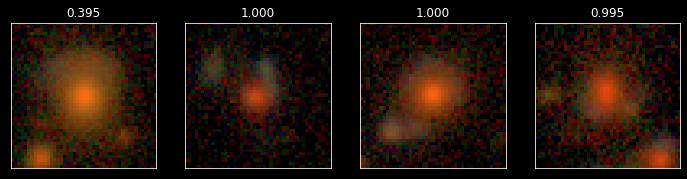

1340791460
1616781749
945447192
914485495


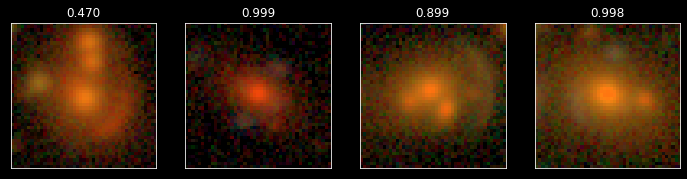

1377288600
1249230135
1050596698
973022479


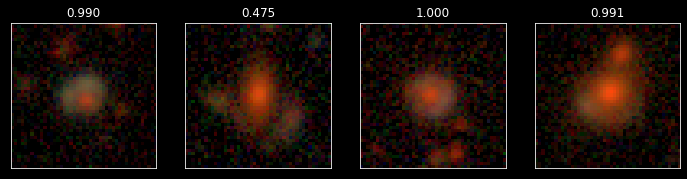

1497925832
1346717256
1518164112
1080776069


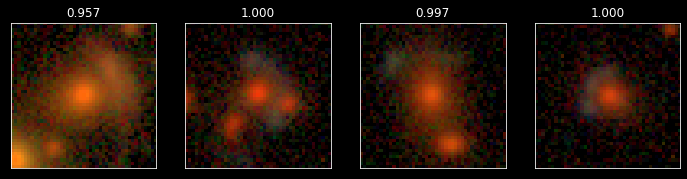

1537991730
914331956
936145598
1099283659


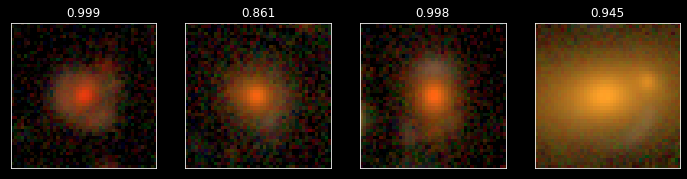

1297126196
1243683190
954133472
1466200592


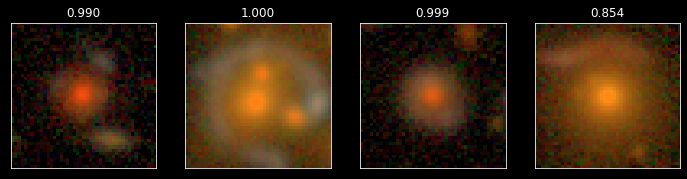

1190538563
984685369
1114488763
1564067702


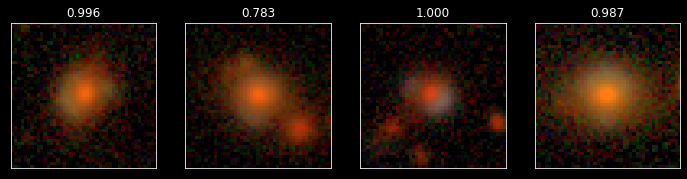

1325770979
1126356733
1484242359
1234418937


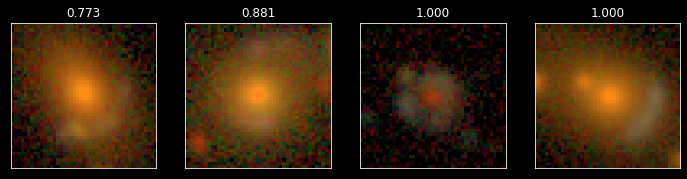

1470342587
1231933469
1444903123
1297510452


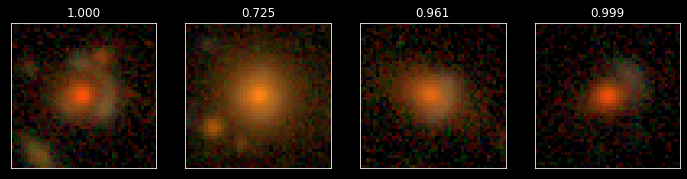

1588291406
906848959
1196484135
1441805121


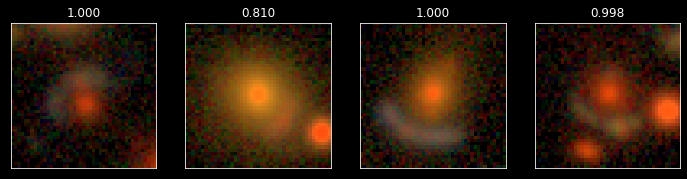

1083587736
1136639478
920111245
1307017630


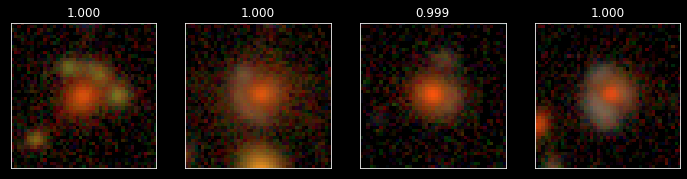

1247311322
1147402803
1520163934
1585510883


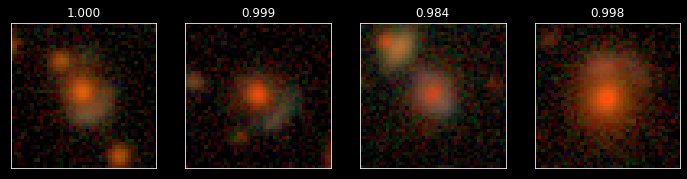

1136340852
1034878415
1210605194
1495778858


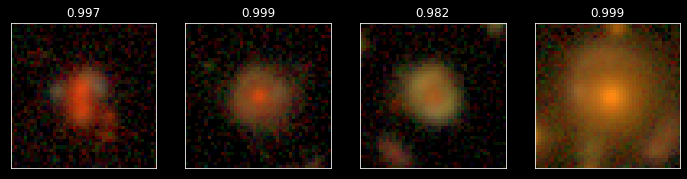

1177839322
1046854003
1591517201
1594751764


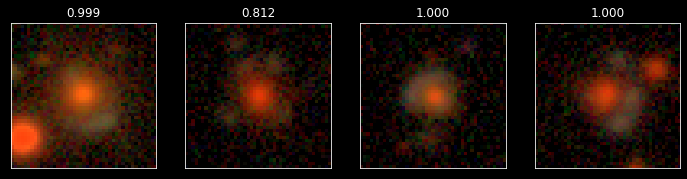

1385113597
1335051094
1613625064
1505900316


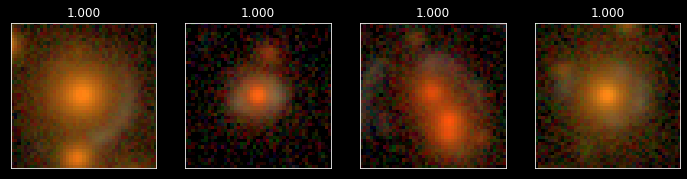

895557736
1301570222
1466401262
1205139711


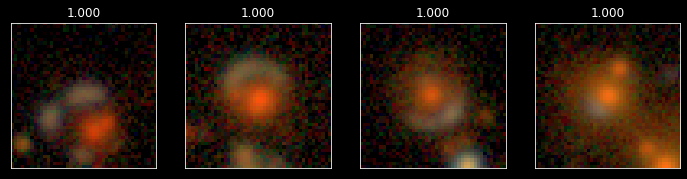

1462363756
947096663
1302030248
1326680132


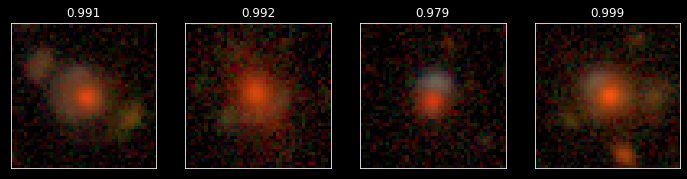

1200974180
1128511911
1386748971
1017262705


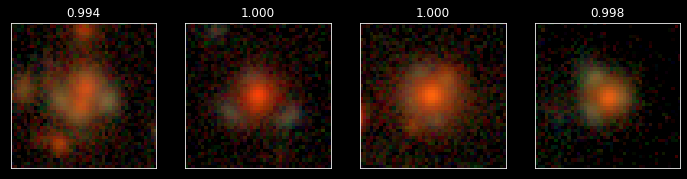

1369578668
921061740
1517936143
1397786541


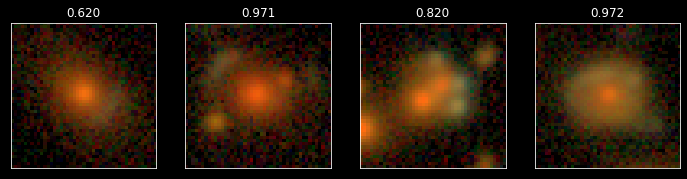

1415379423
1353224538
1169877794
994248020


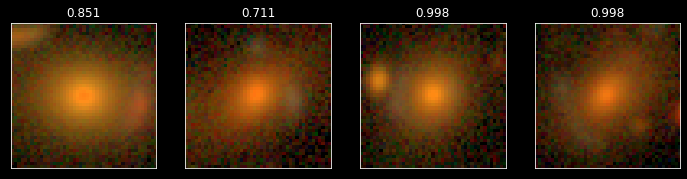

1615848001
1170448654
1171524130
1399999613


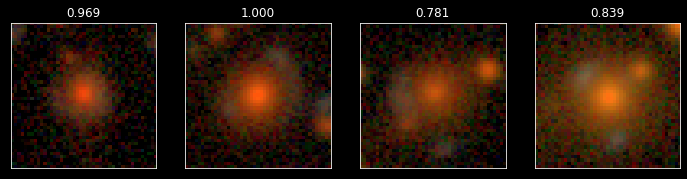

1007321586
1194195904
1493630017
1493707761


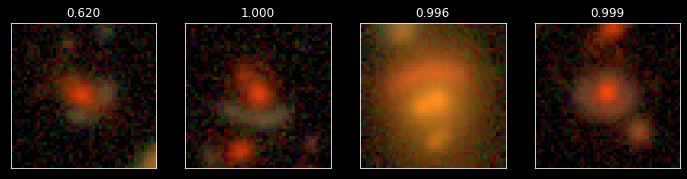

1286124138
1225062343
1067328323
1526034878


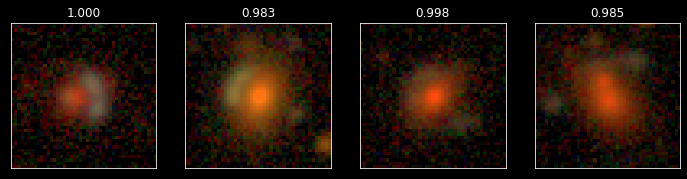

1579060716
1544277856
1128123081
1198903075


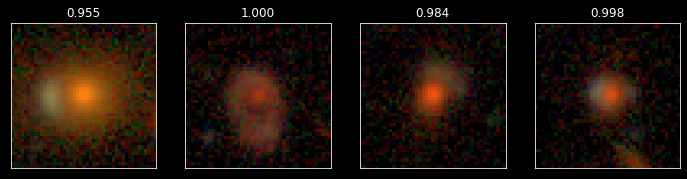

1434471332
1559829914
1507428529
1335651593


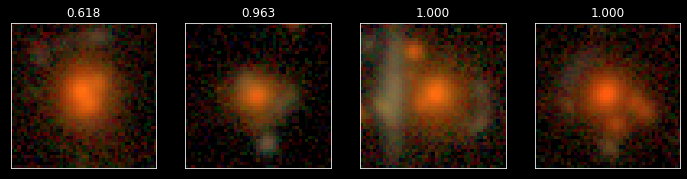

1486397038
997111564
1136960821
1114679464


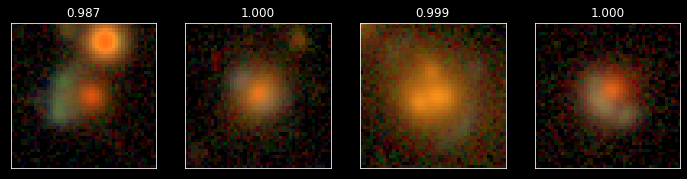

1039481727
1343800193
1483219056
1093259184


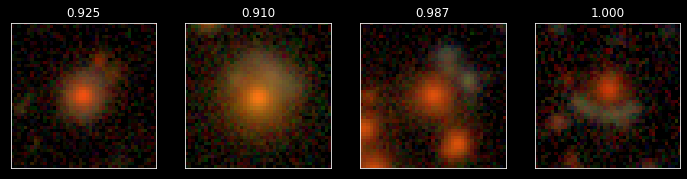

1074454732
1371478188
1313916462
1621540995


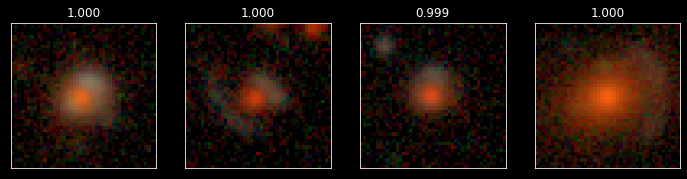

1367533692
1065852196
1179738251
1597714254


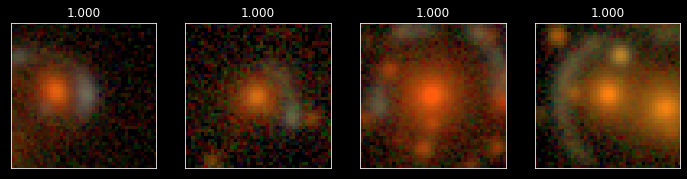

1129303315
1379198488
1171046571
1267465843


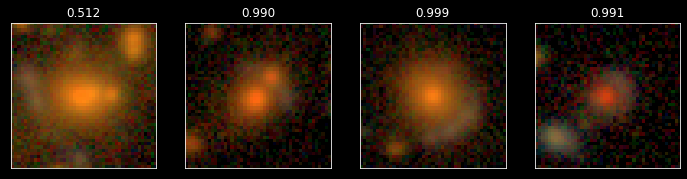

1329554469
1498870663
1238557756
918607334


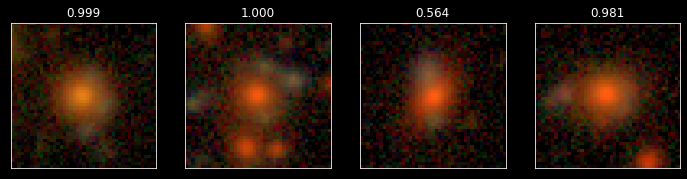

1445672622
1150981093
1428022657
1342755111


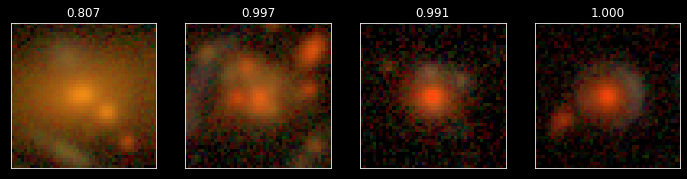

931521165
1194748640
1014709737


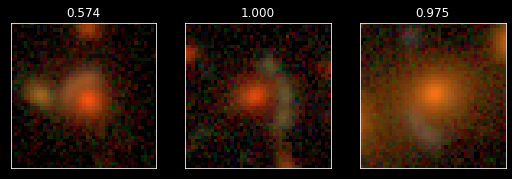

In [15]:
#Identified
print('Identified')
print(categories[0])
make_plot_all(images[0], all_data[0])

In [16]:
names = ['Prob', 'grade', 'photoz', 'imag', 'DNF_ZMEAN_SOF', 'FLUX_RADIUS_G', 'KRON_RADIUS', 'GAP_FLUX_G',
       'MAG_AUTO_G', 'MAG_APER_4_G', 'MAG_APER_8_G']

right_data = right_data[right_data['imag'] < 50]
wrong_data = wrong_data[wrong_data['imag'] < 50]

In [17]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    data_all = np.concatenate((right_data[name], wrong_data[name]))
    plt.hist(data_all, density = True, bins = 'auto', edgecolor = 'black')
    
    
    plt.subplot(1,2,2)
    plt.title(name)
    plt.hist(right_data[name], density = True, bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
    plt.hist(wrong_data[name], density = True, bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
    plt.legend()
    
    plt.show()
        

def make_all_histos():
    for name in names:
        make_histo(name)

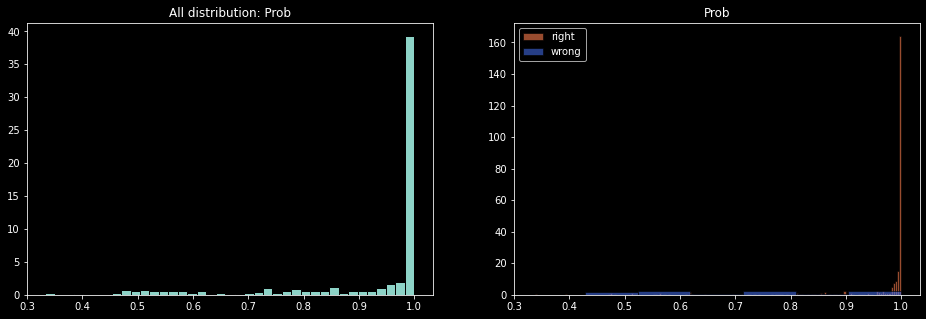

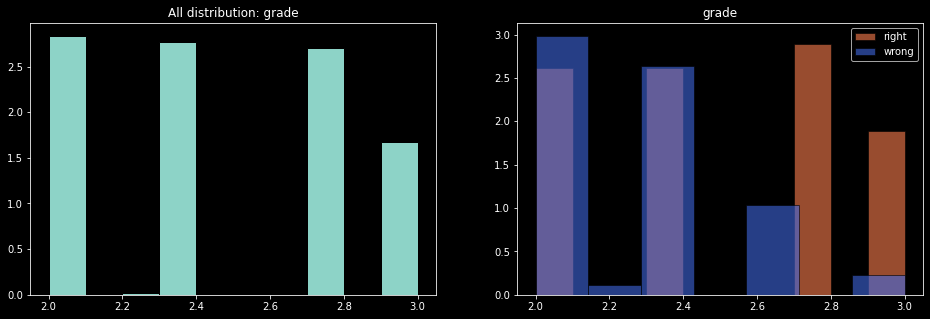

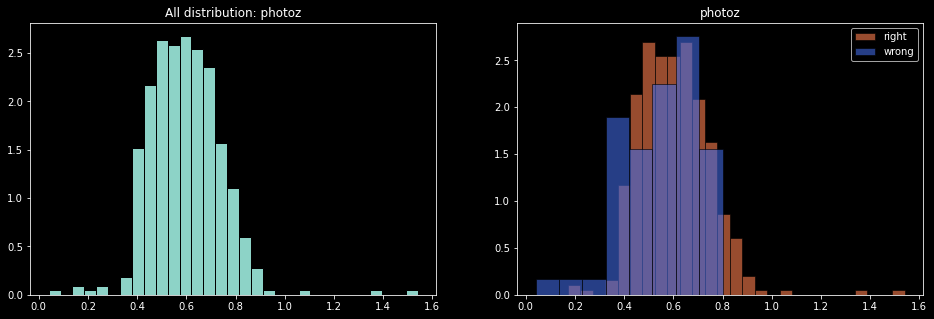

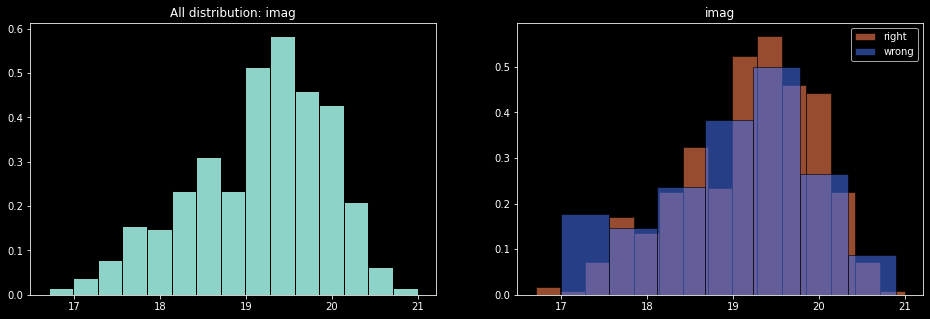

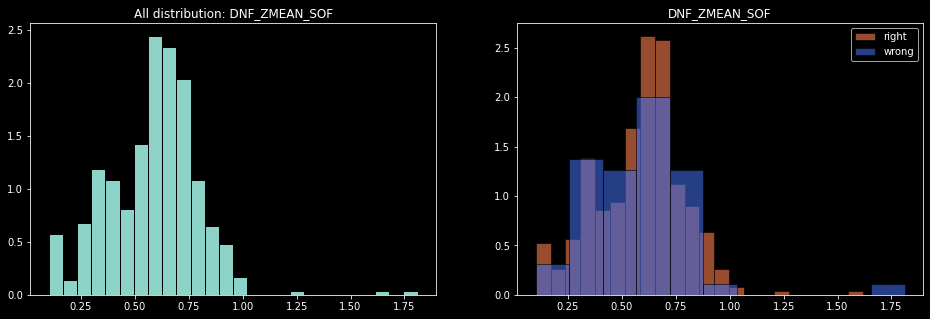

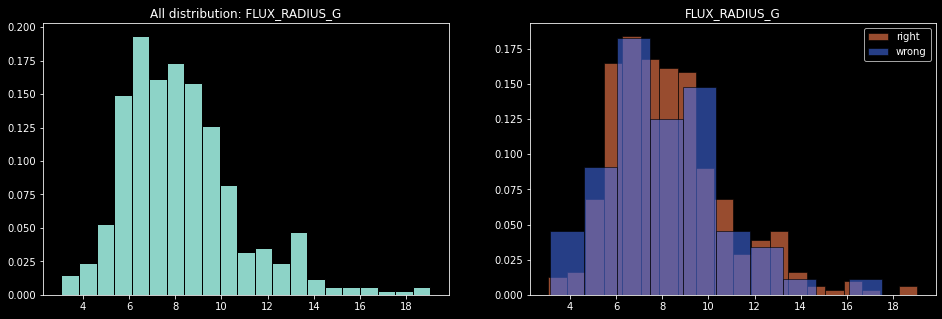

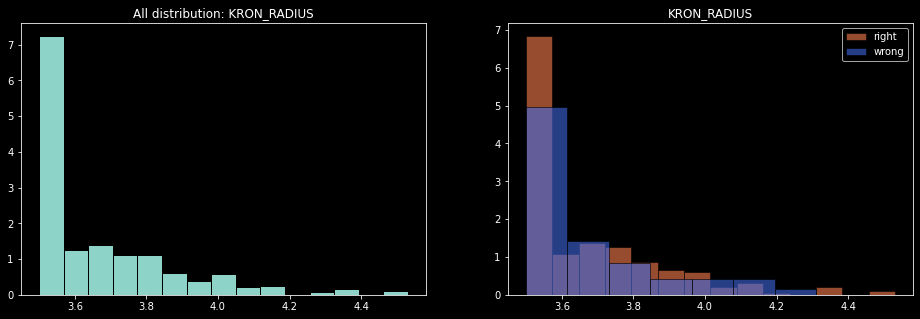

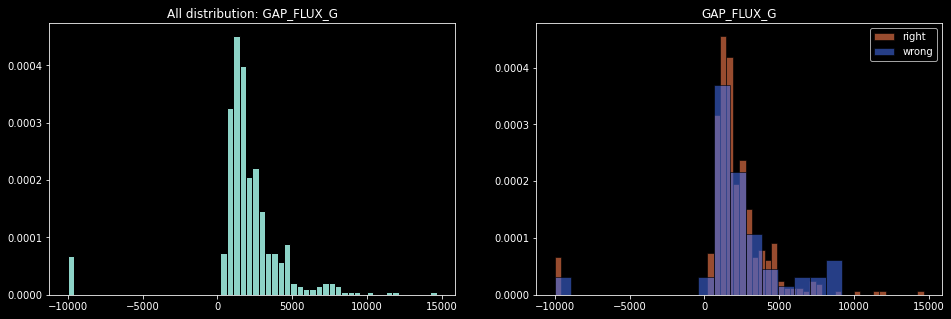

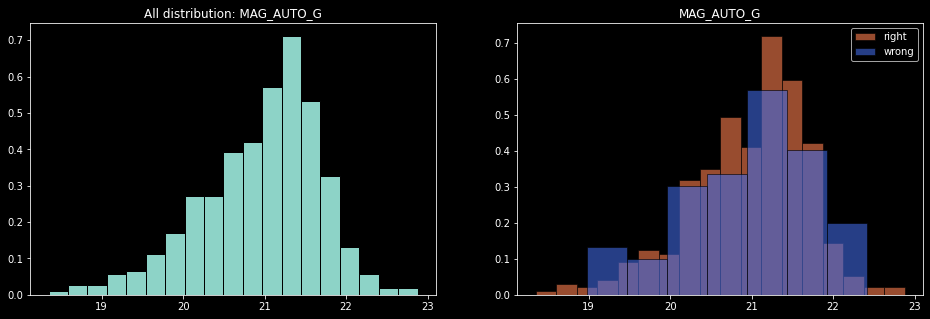

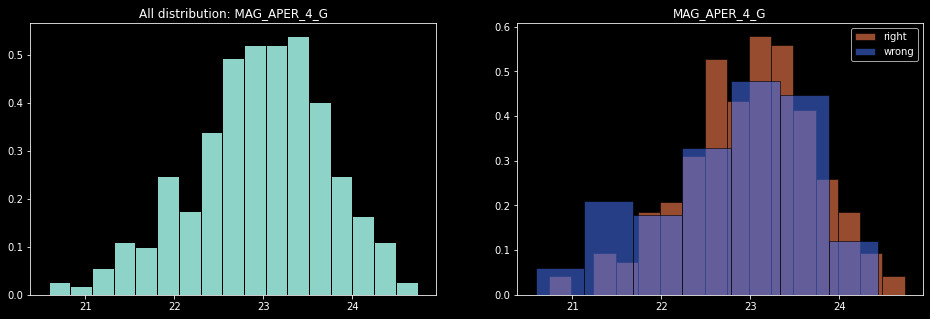

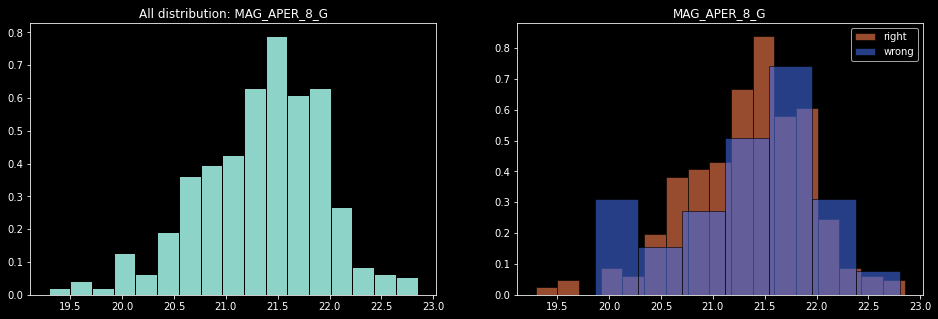

In [18]:
make_all_histos()

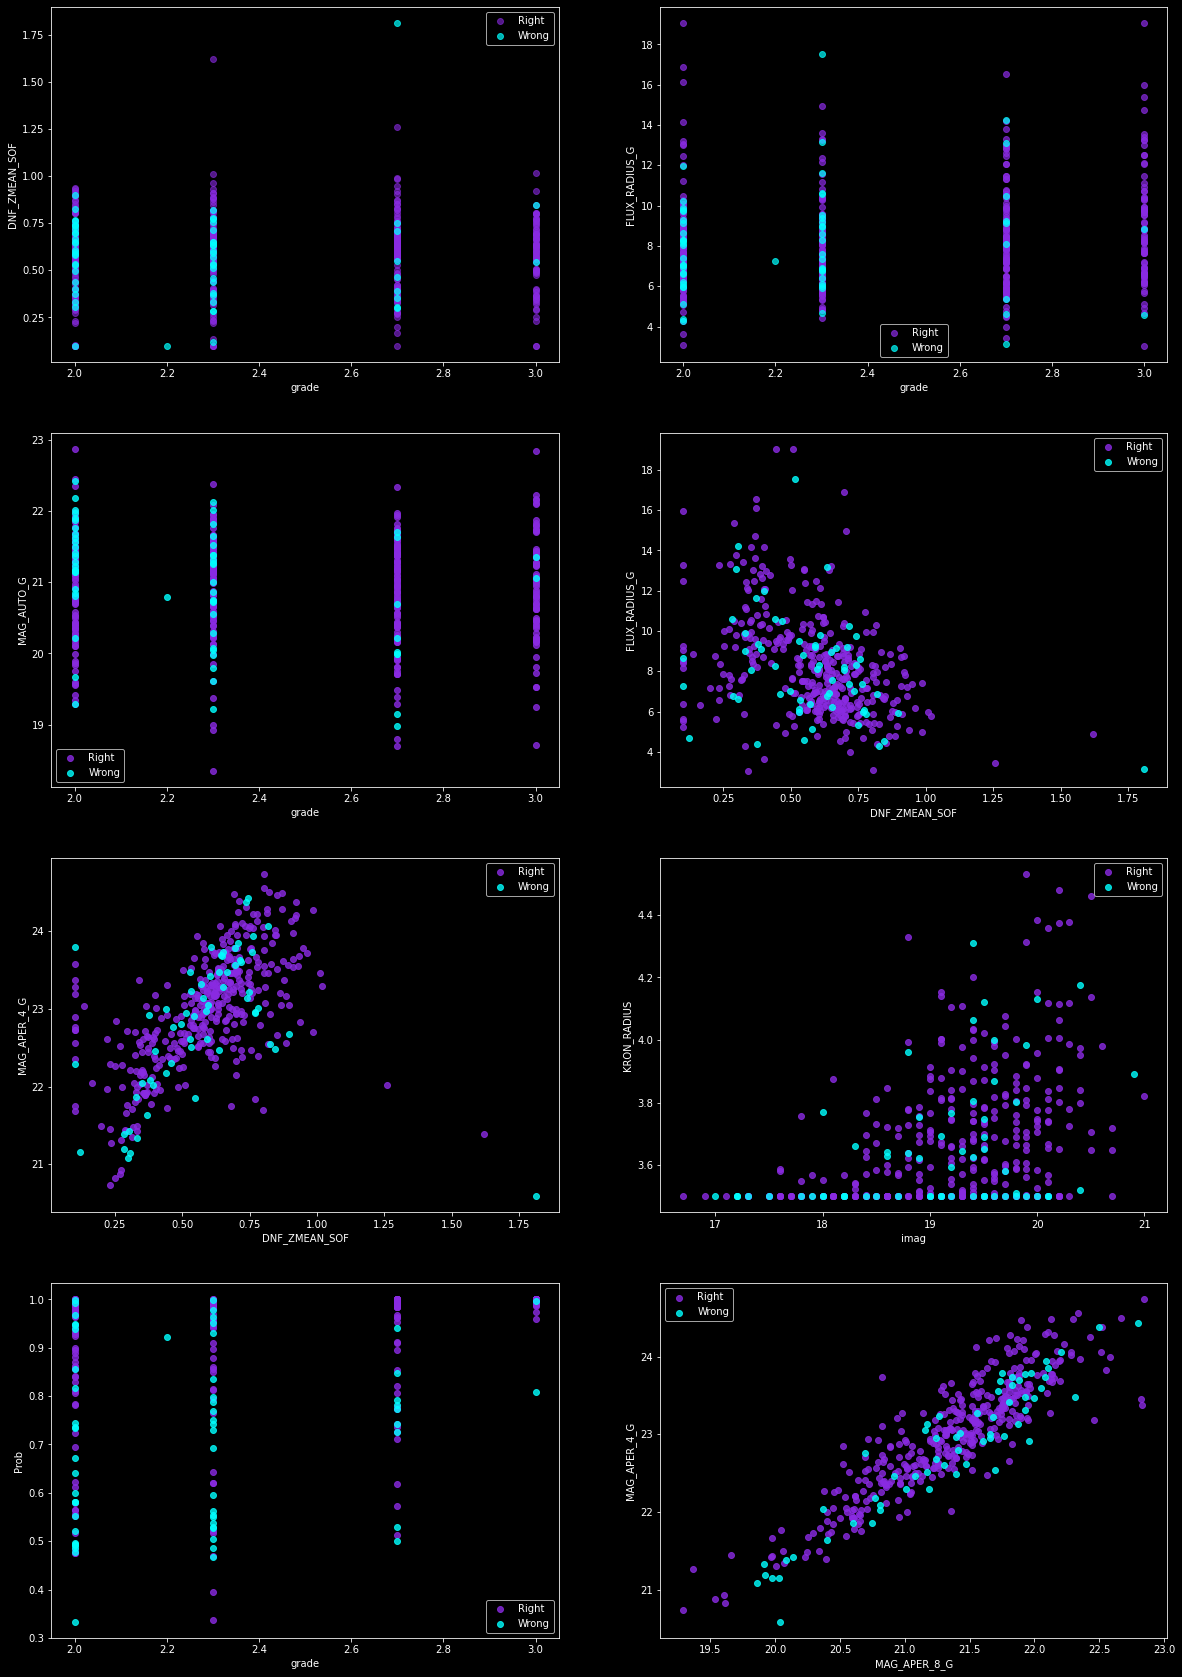

In [19]:
plt.figure(figsize=(20,30)) 

plt.subplot(4,2,1)
plt.xlabel(names[1])
plt.ylabel(names[4])
plt.scatter(right_data[names[1]], right_data[names[4]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[4]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(4,2,2)
plt.xlabel(names[1])
plt.ylabel(names[5])
plt.scatter(right_data[names[1]], right_data[names[5]], color = 'blueviolet', alpha = 0.7, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[5]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(4,2,3)
plt.xlabel(names[1])
plt.ylabel(names[8])
plt.scatter(right_data[names[1]], right_data[names[8]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[8]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,4)
plt.xlabel(names[4])
plt.ylabel(names[5])
plt.scatter(right_data[names[4]], right_data[names[5]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[4]], wrong_data[names[5]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,5)
plt.xlabel(names[4])
plt.ylabel(names[9])
plt.scatter(right_data[names[4]], right_data[names[9]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[4]], wrong_data[names[9]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,6)
plt.xlabel(names[3])
plt.ylabel(names[6])
plt.scatter(right_data[names[3]], right_data[names[6]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[3]], wrong_data[names[6]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 
    
plt.subplot(4,2,7)
plt.xlabel(names[1])
plt.ylabel(names[0])
plt.scatter(right_data[names[1]], right_data[names[0]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[0]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend()     

plt.subplot(4,2,8)
plt.xlabel(names[10])
plt.ylabel(names[9])
plt.scatter(right_data[names[10]], right_data[names[9]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[10]], wrong_data[names[9]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend()   

plt.show()

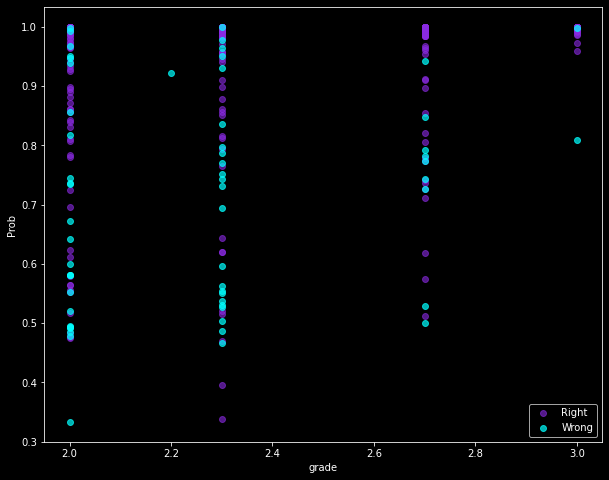

In [20]:
plt.figure(figsize=(10,8)) 

plt.xlabel(names[1])
plt.ylabel(names[0])
plt.scatter(right_data[names[1]], right_data[names[0]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[0]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.show()